In [1]:
import pandas as pd
import numpy as np
import wrds
from pandas.tseries.offsets import *
import pickle as pkl
import pyarrow.feather as feather
import os
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LinearRegression, Lasso
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import spearmanr
import xgboost as xgb
from xgboost import XGBRegressor
from matplotlib.ticker import MaxNLocator
from typing import Dict, List
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore", category=FutureWarning)

def v(x,y=5):
    print(x.shape)
    print(x.head(y))

def cm(df):
    cols_with_nan = df.columns[df.isna().any()].tolist()
    rows_with_nan = df[df.isna().any(axis=1)]
    print(cols_with_nan,rows_with_nan)

### 基石模型

In [2]:
# rank_imputed = pd.read_feather('D:/股票项目/chars60/chars60_rank_imputed.feather')
# rank_not_imputed = pd.read_feather('D:/股票项目/chars60/chars60_rank_no_impute.feather')
# rank_imputed.to_csv('D:/股票项目/chars60/chars60_rank_imputed.csv')
rank_imputed = pd.read_csv('D:/股票项目/chars60/chars60_rank_imputed.csv')
rank_imputed[:1000].to_excel('D:/股票项目/chars60/chars60_rank_impute.xlsx')
rank_imputed = rank_imputed[[col for col in rank_imputed.columns if col!='Unnamed: 0']]

In [3]:
value = rank_imputed.loc[0, 'rank_mom36m']
print(f"值是否等于np.nan: {value == np.nan}")  # 应输出False
print(f"值是否为np.nan: {np.isnan(value)}")     # 应输出True
print(f"值是否为None: {value is None}")          # 应输出False
print(f"值的类型: {type(value)}")                # 应输出<class 'numpy.float64'>

# 检查整个列的情况
nan_mask = rank_imputed['rank_mom36m'].apply(np.isnan)
print(f"该列中被np.isnan识别为nan的数量: {nan_mask.sum()}")
print(f"该列中被pd.isna识别为nan的数量: {rank_imputed['rank_mom36m'].isna().sum()}")

值是否等于np.nan: False
值是否为np.nan: True
值是否为None: False
值的类型: <class 'numpy.float64'>
该列中被np.isnan识别为nan的数量: 15053
该列中被pd.isna识别为nan的数量: 15053


In [4]:
def print_column_types(df):
    """打印DataFrame每列中元素的数据类型分布"""
    for col in df.columns:
        print(f"列名: {col}")
        print("元素类型分布:")
        
        # 获取该列每个元素的类型，并统计每种类型的数量
        type_counts = df[col].apply(type).value_counts()
        print(type_counts)
        print("-" * 50)  # 分隔线

# 使用示例
print_column_types(rank_imputed)

列名: gvkey
元素类型分布:
gvkey
<class 'int'>    332271
Name: count, dtype: int64
--------------------------------------------------
列名: permno
元素类型分布:
permno
<class 'int'>    332271
Name: count, dtype: int64
--------------------------------------------------
列名: sic
元素类型分布:
sic
<class 'int'>    332271
Name: count, dtype: int64
--------------------------------------------------
列名: ret
元素类型分布:
ret
<class 'float'>    332271
Name: count, dtype: int64
--------------------------------------------------
列名: exchcd
元素类型分布:
exchcd
<class 'float'>    332271
Name: count, dtype: int64
--------------------------------------------------
列名: shrcd
元素类型分布:
shrcd
<class 'float'>    332271
Name: count, dtype: int64
--------------------------------------------------
列名: date
元素类型分布:
date
<class 'str'>    332271
Name: count, dtype: int64
--------------------------------------------------
列名: ffi49
元素类型分布:
ffi49
<class 'int'>    332271
Name: count, dtype: int64
--------------------------------------------------


In [5]:
data = rank_imputed.copy()
def fmm(data, group_col='permno'):
    # 1. 分离分组列与数值列
    if group_col not in data.columns:
        raise ValueError(f"分组列'{group_col}'不存在于数据中！")
    
    numeric_cols = data.select_dtypes(include=np.number).columns.drop(group_col)  # 提取数值列（排除分组列）
    if not numeric_cols.size:
        raise ValueError("数据中没有可填充的数值列！")
    
    # 2. 按分组列计算数值列的中位数（处理空分组和全NaN分组）
    group_medians = data.groupby(group_col)[numeric_cols].transform(
        lambda x: x.median() if x.notna().any() else np.nan  # 若分组全为NaN，暂存为NaN
    )
    
    # 3. 用全局中位数填充分组中位数中的NaN（避免全NaN分组无法填充）
    for col in numeric_cols:
        global_median = data[col].median()  # 计算全局中位数
        group_medians[col] = group_medians[col].fillna(global_median)  # 填充NaN分组
    
    # 4. 填充原始数据的缺失值
    data_filled = data.copy()
    data_filled[numeric_cols] = data_filled[numeric_cols].fillna(group_medians)
    
    # 5. 检查填充结果（可选但重要）
    missing_count = data_filled[numeric_cols].isna().sum().sum()
    if missing_count > 0:
        print(f"警告：填充后仍有 {missing_count} 个缺失值，可能因全NaN分组无法填充，建议手动处理或删除相关行。")
    else:
        print("缺失值填充成功！")
    return data_filled
data = fmm(data)
data = data.dropna()
v(data)

缺失值填充成功！
(332271, 70)
   gvkey  permno   sic       ret  exchcd  shrcd        date  ffi49  \
0   1004   54594  5080  0.029534     1.0   11.0  2016-10-31     42   
1   1004   54594  5080  0.146721     1.0   11.0  2016-11-30     42   
2   1004   54594  5080 -0.104093     1.0   11.0  2016-12-31     42   
3   1004   54594  5080 -0.029803     1.0   11.0  2017-01-31     42   
4   1004   54594  5080  0.075961     1.0   11.0  2017-02-28     42   

       lag_me  rank_mom36m  ...  rank_lev  rank_me_ia  rank_cfp  rank_hire  \
0  1070329.68     0.014351  ...  0.167702    0.621118  0.540373        1.0   
1  1099377.58     0.000000  ...  0.099602    0.657371  0.541833        0.0   
2  1260678.86     0.000000  ...  0.072897    0.648598  0.461682        0.0   
3  1134573.45     0.014351  ...  0.143363    0.610619  0.582301       -1.0   
4  1098184.71     0.000000  ...  0.123139    0.610284  0.610284        0.0   

   rank_cashdebt   rank_me  rank_ni  rank_roa  rank_grltnoa     log_me  
0            0.

In [6]:
## 预处理
def preprocess_data(data):
    # 将日期转换为datetime格式并提取年、月
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    
    # 移除包含缺失值的行
    data = data.dropna()
    
    # 创建滞后收益率特征
    data = data.sort_values(['permno', 'date'])
    data['lag_ret_1'] = data.groupby('permno')['ret'].shift(1)
    data['lag_ret_3'] = data.groupby('permno')['ret'].shift(3)
    # data['lag_ret_6'] = data.groupby('permno')['ret'].shift(6)
    
    # 移除包含NaN的行（由于滞后操作产生）
    data = data.dropna()
    
    return data

In [7]:
## 行业数据
def engineer_features(data):
    # 计算每个月的股票数量
    monthly_stocks = data.groupby(['year', 'month'])['permno'].count().reset_index()
    monthly_stocks.rename(columns={'permno': 'monthly_stocks'}, inplace=True)
    data = pd.merge(data, monthly_stocks, on=['year', 'month'], how='left')
    
    # 计算行业平均收益率
    industry_ret = data.groupby(['ffi49', 'year', 'month'])['ret'].mean().reset_index()
    industry_ret.rename(columns={'ret': 'industry_ret'}, inplace=True)
    data = pd.merge(data, industry_ret, on=['ffi49', 'year', 'month'], how='left')
    
    # 计算市场平均收益率
    market_ret = data.groupby(['year', 'month'])['ret'].mean().reset_index()
    market_ret.rename(columns={'ret': 'market_ret'}, inplace=True)
    data = pd.merge(data, market_ret, on=['year', 'month'], how='left')
    
    return data

In [8]:
## 准备建模数据
def prepare_model_data(data, features, target='ret'):
    # 分割特征和目标变量
    X = data[features]
    y = data[target]
    
    # 时间分割（使用最后12个月作为测试集）
    test_years = data['year'].unique()[-1]
    test_months = [i for i in range(1, 13)]
    
    train_idx = ~((data['year'] == test_years) & (data['month'].isin(test_months)))
    test_idx = (data['year'] == test_years) & (data['month'].isin(test_months))
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 保存日期和股票标识用于后续分析
    train_info = data[train_idx][['permno', 'date']]
    test_info = data[test_idx][['permno', 'date']]
    
    # 特征标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, train_info, test_info

In [15]:
## 训练评估
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(alpha=0.01),
        # 'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
        # 'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
        # 'XGB': XGBRegressor(n_estimators=100, max_depth=3, random_state=42, learning_rate=0.1)
    }
    
    results = {}
    
    for name, model in models.items():
        # 训练模型
        model.fit(X_train, y_train)
        
        # 预测
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # 评估
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        results[name] = {
            'model': model,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'y_test_pred': y_test_pred,
            'y_train_pred': y_train_pred
        }
        
        print(f"{name} - Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")
        print(f"{name} - Train R^2: {train_r2:.6f}, Test R^2: {test_r2:.6f}")
    
    return results

In [16]:
## 特征重要性
def analyze_feature_importance(model, feature_names, top_n=10):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = model.coef_
    else:
        print("模型不支持特征重要性分析")
        return None
    
    # 创建特征重要性数据框
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    
    # 按重要性排序
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # 绘制特征重要性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
    plt.title('Top {} Feature Importances'.format(top_n))
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    
    return importance_df.head(top_n)

In [17]:
## 资产组合分析
def portfolio_analysis(test_info, y_test, y_test_pred, n_portfolios=5):
    # 创建结果数据框
    results = pd.DataFrame({
        'permno': test_info['permno'].values,
        'date': test_info['date'].values,
        'actual_ret': y_test.values,
        'predicted_ret': y_test_pred
    })
    
    # 按月分组并构建投资组合
    portfolio_returns = []
    months = results['date'].unique()
    
    for month in months:
        month_data = results[results['date'] == month].copy()
        
        # 根据预测收益率排序
        month_data = month_data.sort_values('predicted_ret', ascending=False)
        
        # 划分投资组合
        portfolio_size = len(month_data) // n_portfolios
        for i in range(n_portfolios):
            start = i * portfolio_size
            end = start + portfolio_size if i < n_portfolios - 1 else len(month_data)
            portfolio = month_data.iloc[start:end]
            
            # 计算等权重组合收益率
            portfolio_return = portfolio['actual_ret'].mean()
            
            portfolio_returns.append({
                'month': month,
                'portfolio': i + 1,
                'return': portfolio_return
            })
    
    # 转换为数据框
    portfolio_df = pd.DataFrame(portfolio_returns)
    
    # 计算每个投资组合的平均收益率
    avg_returns = portfolio_df.groupby('portfolio')['return'].mean()
    
    # 计算多空策略收益率
    long_short_return = avg_returns.iloc[0] - avg_returns.iloc[-1]
    
    # 绘制投资组合收益图
    plt.figure(figsize=(10, 6))
    sns.barplot(x='portfolio', y='return', data=portfolio_df)
    plt.title('Portfolio Returns')
    plt.xlabel('Portfolio')
    plt.ylabel('Average Return')
    plt.tight_layout()
    plt.savefig('portfolio_returns.png')
    plt.close()
    
    return avg_returns, long_short_return

In [20]:
def main():
    # 数据预处理
    processed_data = preprocess_data(data)
    
    # 特征工程
    engineered_data = engineer_features(processed_data)
    
    # 选择特征
    all_features = [col for col in engineered_data.columns if col not in ['gvkey','permno', 'date', 'ret', 'year', 'month', 'exchcd','shrcd']]
    
    # 准备建模数据
    X_train, X_test, y_train, y_test, train_info, test_info = prepare_model_data(
        engineered_data, all_features, target='ret'
    )
    
    # 训练所有模型并获取预测结果
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test)
    
    # 创建包含所有模型预测结果的DataFrame
    predictions_df = pd.DataFrame({
        'date': pd.concat([train_info['date'], test_info['date']]),
        'permno': pd.concat([train_info['permno'], test_info['permno']]),
        'actual_ret': pd.concat([y_train, y_test])
    })
    
    # 添加每个模型的预测结果
    for model_name in results.keys():
        predictions_df[f'predicted_ret_{model_name}'] = np.concatenate([
            results[model_name]['y_train_pred'], 
            results[model_name]['y_test_pred']
        ])
    
    # 保存到Excel文件
    predictions_df.to_excel('D:/股票项目/basic_predictions.xlsx', index=False)
    
    # 特征重要性分析（以随机森林为例）
    rf_model = results['Lasso Regression']['model']
    top_features = analyze_feature_importance(rf_model, all_features)
    print("\nTop Features:")
    print(top_features)

    
    # 投资组合分析（以随机森林预测为例）
    rf_predictions = results['Lasso Regression']['y_test_pred']
    avg_returns, long_short_return = portfolio_analysis(test_info, y_test, rf_predictions)
    print("\nPortfolio Returns:")
    print(avg_returns)
    print(f"\nLong-Short Return: {long_short_return:.6f}")

In [21]:
if __name__ == "__main__":
    main()    

Linear Regression - Train MSE: 0.045570, Test MSE: 0.014632
Linear Regression - Train R^2: 0.134638, Test R^2: 0.295499
Lasso Regression - Train MSE: 0.045780, Test MSE: 0.014783
Lasso Regression - Train R^2: 0.130657, Test R^2: 0.288245

Top Features:
           Feature  Importance
67    industry_ret    0.073549
0              sic   -0.000000
43        rank_rna    0.000000
49       rank_turn   -0.000000
48  rank_zerotrade   -0.000000
47      rank_mom6m    0.000000
46     rank_chcsho   -0.000000
45        rank_gma    0.000000
44  rank_rvar_capm   -0.000000
42     rank_mom60m    0.000000

Portfolio Returns:
portfolio
1    0.083013
2    0.033083
3    0.015842
4   -0.005862
5   -0.049480
Name: return, dtype: float64

Long-Short Return: 0.132493


### 窗口模型

In [11]:
processed_data = preprocess_data(data)
edata = engineer_features(processed_data)
edata

,gvkey,permno,sic,ret,exchcd,shrcd,date,ffi49,lag_me,rank_mom36m,...,rank_roa,rank_grltnoa,log_me,year,month,lag_ret_1,lag_ret_3,monthly_stocks,industry_ret,market_ret
0,12825,10026,2050,-0.033289,3.0,11.0,2017-05-31,2,2.519068e+06,0.122405,...,0.667826,0.000000,14.739400,2017,5,-0.007229,0.048836,726,-0.045933,-0.008713
1,12825,10026,2050,0.018371,3.0,11.0,2017-06-30,2,2.435212e+06,0.000000,...,0.675408,0.480519,14.705544,2017,6,-0.033289,0.016293,764,-0.004490,0.015313
2,12825,10026,2050,-0.005073,3.0,11.0,2017-07-31,2,2.473539e+06,0.000000,...,0.671441,0.662420,14.721161,2017,7,0.018371,-0.007229,807,0.008039,0.000371
3,12825,10026,2050,-0.029756,3.0,11.0,2017-08-31,2,2.462304e+06,0.000000,...,0.839416,0.273617,14.716608,2017,8,-0.005073,-0.033289,3421,-0.027544,-0.016907
4,12825,10026,2050,0.033179,3.0,11.0,2017-09-30,2,2.389035e+06,0.000000,...,0.841316,0.271078,14.686400,2017,9,-0.029756,0.018371,3402,0.045498,0.073296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316382,184996,93436,3711,-0.077391,3.0,11.0,2024-08-31,23,7.413801e+08,0.110106,...,0.551696,-0.200882,20.424024,2024,8,0.172781,-0.028372,3679,-0.081720,-0.024281
316383,184996,93436,3711,0.221942,3.0,11.0,2024-09-30,23,6.840044e+08,0.141393,...,0.551432,-0.200127,20.343475,2024,9,-0.077391,0.111186,3658,-0.044205,0.003945
316384,184996,93436,3711,-0.045025,3.0,11.0,2024-10-31,23,8.390474e+08,-0.015357,...,0.547253,-0.198337,20.547778,2024,10,0.221942,0.172781,3629,-0.058508,-0.001507
316385,184996,93436,3711,0.381469,3.0,11.0,2024-11-30,23,8.020335e+08,-0.099911,...,0.651624,-0.232676,20.502661,2024,11,-0.045025,-0.077391,3624,0.046959,0.100034


In [12]:
class FactorStateGenerator:
    def __init__(self, n_factors, decay_rate=0.95, threshold=0.01):
        self.state_series = [np.ones(n_factors)]  # 初始状态全启用
        self.perf_metrics = [np.zeros(n_factors)]  # 因子表现指标
        self.decay_rate = decay_rate
        self.threshold = threshold
    
    def update_state(self, current_perf):
        # 加权平均计算综合表现
        prev_metric = self.perf_metrics[-1] * self.decay_rate
        new_metric = prev_metric + (1 - self.decay_rate) * current_perf
        
        # 生成新状态：0=启用，1=禁用
        new_state = np.where(np.abs(new_metric) > self.threshold, 0, 1)
        
        self.perf_metrics.append(new_metric)
        self.state_series.append(new_state)
        return new_state

In [84]:
class DynamicFactorModel:
    def __init__(self, factors, window_size=12, min_factors=2, 
                 date_col='date', return_col='ret', id_col='permno', ic_lookback=12):
        # 新增参数：ic_lookback=12（默认使用过去12期IC）
        self.factors = factors
        self.window_size = window_size
        self.min_factors = min_factors
        self.state_generator = FactorStateGenerator(len(factors))
        self.models = {}
        self.date_col = date_col
        self.return_col = return_col
        self.id_col = id_col
        self.ic_lookback = ic_lookback  # 历史IC回顾期数
        self.predictions_df = None  # 初始化预测结果存储
        
        # XGBoost参数配置
        self.xgb_params = {
            'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1,
            'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 1,
            'reg_lambda': 1, 'objective': 'reg:squarederror', 
            'random_state': 42, 'n_jobs': -1
        }
        
        # 存储历史IC（key: date, value: 各因子IC值数组）
        self.historical_ics = {}

    def calculate_historical_ic(self, df):
        """离线计算所有历史IC（用于预测时的因子选择）"""
        df = df.sort_values(self.date_col)
        dates = df[self.date_col].unique()
        
        for i in range(len(dates) - 1):
            current_date = dates[i]
            next_date = dates[i+1]  # 修正：应该是i+1，而不是i
            
            # 提取t期因子和t+1期收益
            factor_data = df[df[self.date_col] == current_date]
            return_data = df[df[self.date_col] == next_date]
            
            if factor_data.empty or return_data.empty:
                continue
                
            # 合并数据
            merged = pd.merge(
                factor_data[[self.id_col] + self.factors],
                return_data[[self.id_col, self.return_col]],
                on=self.id_col,
                how='inner'
            )
            
            # 跳过数据不足的情况
            if len(merged) < 2:
                self.historical_ics[current_date] = np.zeros(len(self.factors))
                continue
            
            # 计算IC并存储
            ic_values = []
            for factor in self.factors:
                if np.std(merged[factor]) < 1e-10:
                    ic_values.append(0.0)
                else:
                    try:
                        ic, _ = spearmanr(merged[factor], merged[self.return_col])
                        ic_values.append(ic if not np.isnan(ic) else 0.0)
                    except:
                        ic_values.append(0.0)
            self.historical_ics[current_date] = np.array(ic_values)

    def get_rolling_avg_ic(self, current_date):
        """获取当前日期之前的滚动平均IC"""
        # 筛选历史IC中早于current_date的记录
        valid_dates = [d for d in self.historical_ics.keys() if d < current_date]
        valid_dates.sort()
        
        # 取最近ic_lookback期的IC
        start_idx = max(0, len(valid_dates) - self.ic_lookback)
        recent_ics = [self.historical_ics[d] for d in valid_dates[start_idx:]]
        
        if not recent_ics:
            return np.zeros(len(self.factors))  # 无历史数据时默认IC为0
        return np.mean(recent_ics, axis=0)

    def train_predict(self, df):
        df = df.copy()  # 避免修改原始数据
        df[self.date_col] = pd.to_datetime(df[self.date_col])
        df = df.sort_values(self.date_col)
        dates = df[self.date_col].unique()
        
        # 先离线计算所有历史IC（仅在第一次调用时执行）
        if not self.historical_ics:
            self.calculate_historical_ic(df)
        
        state_history = []
        all_predictions = []  # 收集每次预测的完整DataFrame
        
        for i in range(self.window_size, len(dates) - 1):
            train_end_date = dates[i]       
            predict_date = dates[i + 1]     
            
            # 获取历史平均IC（用于选择因子，不使用未来收益）
            factor_perf = self.get_rolling_avg_ic(train_end_date)
            
            # 更新因子状态（基于历史平均IC）
            current_state = self.state_generator.update_state(factor_perf)
            state_history.append((train_end_date, current_state.copy()))
            
            # 筛选活跃因子
            active_factors = [f for j, f in enumerate(self.factors) if current_state[j] == 0]
            if len(active_factors) < self.min_factors:
                sorted_idx = np.argsort(np.abs(factor_perf))[::-1]
                active_factors = [self.factors[idx] for idx in sorted_idx[:self.min_factors]]
            
            # 训练模型：使用截止到train_end_date的历史数据
            train_data = df[df[self.date_col] <= train_end_date]  # 包含截止日期
            
            # 清理训练数据中的NaN值
            train_data_clean = train_data.dropna(subset=active_factors + [self.return_col])
            
            # 跳过数据不足的情况
            if len(train_data_clean) < 10:
                print(f"警告: 训练数据不足 ({len(train_data_clean)}样本)，跳过日期 {train_end_date}")
                continue
                
            model = XGBRegressor(**self.xgb_params)
            model.fit(
                train_data_clean[active_factors],
                train_data_clean[self.return_col],
                eval_set=[(train_data_clean[active_factors], train_data_clean[self.return_col])],
                verbose=False
            )
            self.models[train_end_date] = (model, active_factors)
            
            # 预测：使用train_end_date的因子数据
            test_data = df[df[self.date_col] == train_end_date]
            if test_data.empty:
                continue
            
            # 处理因子缺失
            missing_factors = set(active_factors) - set(test_data.columns)
            if missing_factors:
                print(f"警告: 缺失因子 {missing_factors}，跳过预测")
                continue
            
            # 清理测试数据中的NaN值
            test_data_clean = test_data.dropna(subset=active_factors)
            if test_data_clean.empty:
                print(f"警告: 测试数据全部为NaN，跳过预测 {train_end_date}")
                continue
                
            pred = model.predict(test_data_clean[active_factors])
            
            # 获取实际收益（预测阶段未知，验证时才需要，但代码中需兼容回测）
            actual_data = df[df[self.date_col] == predict_date]
            
            # 创建预测结果DataFrame
            pred_df = pd.DataFrame({
                self.date_col: predict_date,
                self.id_col: test_data_clean[self.id_col].values,
                'prediction': pred
            })
            
            # 合并实际收益（如果有）
            if not actual_data.empty:
                pred_df = pd.merge(
                    pred_df,
                    actual_data[[self.id_col, self.return_col]].rename(columns={self.return_col: 'actual'}),
                    on=self.id_col,
                    how='left'
                )
            else:
                pred_df['actual'] = np.nan
            
            # 添加活跃因子信息
            pred_df['active_factors'] = ', '.join(active_factors)
            
            all_predictions.append(pred_df)
        
        # 合并所有预测结果
        if all_predictions:
            self.predictions_df = pd.concat(all_predictions, ignore_index=True)
            # 移除实际值中的NaN
            self.predictions_df = self.predictions_df.dropna(subset=['actual'])
        else:
            self.predictions_df = pd.DataFrame()
            
        # 准备评估数据
        if not self.predictions_df.empty:
            predictions = self.predictions_df['prediction'].values
            actuals = self.predictions_df['actual'].values
        else:
            predictions, actuals = np.array([]), np.array([])
            
        return predictions, actuals, state_history

    # 评估方法
    def evaluate(self, predictions=None, actuals=None):
        # 如果没有提供参数，使用类属性中的数据
        if predictions is None or actuals is None:
            if self.predictions_df is None or self.predictions_df.empty:
                return {'Error': '无有效预测结果'}
                
            predictions = self.predictions_df['prediction'].values
            actuals = self.predictions_df['actual'].values
        
        # 检查数据有效性
        if len(predictions) == 0 or len(actuals) == 0:
            return {'Error': '无有效预测结果'}
        
        # 确保没有NaN值
        mask = ~np.isnan(predictions) & ~np.isnan(actuals)
        predictions = predictions[mask]
        actuals = actuals[mask]
        
        if len(predictions) == 0:
            return {'Error': '过滤后无有效预测结果'}
        
        # 计算评估指标
        mse = mean_squared_error(actuals, predictions)
        return {
            'MSE': mse, 
            'RMSE': np.sqrt(mse),
            'R²': r2_score(actuals, predictions),
            'Number of Predictions': len(actuals),
            'Correlation': np.corrcoef(actuals, predictions)[0, 1]
        }
    
    def save_predictions(self, file_path, file_format='xlsx'):
        """保存预测结果到文件"""
        if self.predictions_df is None or self.predictions_df.empty:
            raise ValueError("无预测结果可保存")
        
        # 创建副本避免修改原始数据
        output_df = self.predictions_df.copy()
        
        # 重命名列
        output_df = output_df.rename(columns={
            self.date_col: 'date',
            self.id_col: 'permno',
            'prediction': 'predicted_ret_icwindow',
            'actual': 'actual_ret'
        })
        
        # 选择需要保存的列
        save_cols = ['date', 'permno', 'predicted_ret_icwindow', 'actual_ret', 'active_factors']
        output_df = output_df[[col for col in save_cols if col in output_df]]
        
        # 确保目录存在
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        
        if file_format == 'xlsx':
            output_df.to_excel(file_path, index=False)
        elif file_format == 'csv':
            output_df.to_csv(file_path, index=False)
        else:
            raise ValueError("不支持的格式，请使用 'xlsx' 或 'csv'")

In [21]:
# 模型工厂相关类
class ModelFactory:
    """模型工厂类，用于创建不同的预测模型"""
    @staticmethod
    def create_model(model_type, **params):
        """创建指定类型的模型"""
        if model_type == 'xgb':
            from xgboost import XGBRegressor
            return XGBModel(XGBRegressor, **params)
        elif model_type == 'rf':
            from sklearn.ensemble import RandomForestRegressor
            return SklearnModel(RandomForestRegressor, **params)
        elif model_type == 'enet':
            from sklearn.linear_model import ElasticNet
            return SklearnModel(ElasticNet, **params)
        elif model_type == 'mlp':
            from sklearn.neural_network import MLPRegressor
            return SklearnModel(MLPRegressor, **params)
        else:
            raise ValueError(f"不支持的模型类型: {model_type}")

class BaseModel:
    """模型基类，定义模型接口"""
    
    def __init__(self, model_class, **params):
        self.model_class = model_class
        self.params = params
        self.model = self.model_class(**self.params)
        
    def fit(self, X, y, **kwargs):
        """训练模型"""
        self.model.fit(X, y, **kwargs)
        
    def predict(self, X):
        """模型预测"""
        return self.model.predict(X)

class XGBModel(BaseModel):
    """XGBoost模型实现"""
    
    def fit(self, X, y, eval_set=None, verbose=False):
        """重写fit方法以支持XGBoost的特性"""
        self.model.fit(X, y, eval_set=eval_set, verbose=verbose)

class SklearnModel(BaseModel):
    """scikit-learn模型实现"""
    
    def fit(self, X, y, **kwargs):
        """适配scikit-learn模型的fit方法"""
        # 忽略不支持的参数
        unsupported_kwargs = ['eval_set', 'verbose']
        for key in unsupported_kwargs:
            if key in kwargs:
                kwargs.pop(key)
                
        super().fit(X, y, **kwargs)

In [ ]:
class DynamicFactorModel:
    def __init__(self, factors, window_size=12, min_factors=2, 
                 date_col='date', return_col='ret', id_col='permno', ic_lookback=12,
                 model_types=['xgb'], model_params=None):
        # 新增参数：ic_lookback=12（默认使用过去12期IC）
        self.factors = factors
        self.window_size = window_size
        self.min_factors = min_factors
        self.state_generator = FactorStateGenerator(len(factors))
        self.models = {}  # 格式: {date: {model_type: (model, active_factors)}}
        self.date_col = date_col
        self.return_col = return_col
        self.id_col = id_col
        self.ic_lookback = ic_lookback  # 历史IC回顾期数
        self.predictions_df = None  # 初始化预测结果存储
        
        # 模型配置
        self.model_types = model_types
        self.model_params = model_params or {}
        
        # 设置不同模型的默认参数
        for model_type in self.model_types:
            if model_type == 'xgb' and model_type not in self.model_params:
                # XGBoost默认参数配置 - 使用更小的系数和更多树
                self.model_params[model_type] = {
                    'n_estimators': 200,      # 更多树
                    'max_depth': 3,           # 小深度
                    'learning_rate': 0.05,    # 较小的学习率
                    'subsample': 0.8,         # 子采样率
                    'colsample_bytree': 0.8,  # 列采样率
                    'reg_alpha': 1.0,         # L1正则化
                    'reg_lambda': 1.0,        # L2正则化
                    'gamma': 0.1,             # 节点分裂所需的最小损失减少
                    'min_child_weight': 1,    # 子节点所需的最小权重和
                    'objective': 'reg:squarederror', 
                    'random_state': 42,
                    'n_jobs': -1
                }
            elif model_type == 'rf' and model_type not in self.model_params:
                # 随机森林默认参数配置
                self.model_params[model_type] = {
                    'n_estimators': 200,      # 更多树
                    'max_depth': 5,           # 限制树深度
                    'min_samples_split': 5,   # 最小分裂样本数
                    'min_samples_leaf': 2,    # 最小叶子节点样本数
                    'max_features': 'sqrt',   # 特征采样方式
                    'random_state': 42,
                    'n_jobs': -1
                }
            elif model_type == 'enet' and model_type not in self.model_params:
                # 弹性网络默认参数配置 - 提供更多参数选项
                self.model_params[model_type] = {
                    'alpha': 0.1,             # 正则化强度
                    'l1_ratio': 0.5,          # L1/L2比例
                    'fit_intercept': True,    # 是否拟合截距
                    'max_iter': 1000,         # 最大迭代次数
                    'tol': 1e-4,              # 收敛容差
                    'random_state': 42
                }
            elif model_type == 'mlp' and model_type not in self.model_params:
                # MLP神经网络默认参数配置
                self.model_params[model_type] = {
                    'hidden_layer_sizes': (50, 30),  # 两层隐藏层
                    'activation': 'relu',            # 激活函数
                    'solver': 'adam',                # 优化器
                    'alpha': 0.0001,                 # L2正则化参数
                    'batch_size': 'auto',            # 批次大小
                    'learning_rate': 'adaptive',     # 学习率策略
                    'learning_rate_init': 0.001,     # 初始学习率
                    'max_iter': 1000,                # 最大迭代次数
                    'shuffle': True,                 # 是否打乱数据
                    'random_state': 42,
                    'tol': 1e-4,                     # 收敛容差
                    'early_stopping': True,          # 是否早停
                    'validation_fraction': 0.1       # 验证集比例
                }

        # 设置不同模型的默认参数
        # for model_type in self.model_types:
        #     if model_type == 'xgb' and model_type not in self.model_params:
        #         # 优化XGBoost参数 - 减少树数量、增大学习率、降低内存占用
        #         self.model_params[model_type] = {
        #             'n_estimators': 50,          # 减少树的数量
        #             'max_depth': 3,               # 保持小深度
        #             'learning_rate': 0.1,         # 增大学习率加速收敛
        #             'subsample': 0.6,             # 降低子采样率减少内存使用
        #             'colsample_bytree': 0.6,      # 降低列采样率
        #             'reg_alpha': 0.5,             # 减小L1正则化
        #             'reg_lambda': 0.5,            # 减小L2正则化
        #             'gamma': 0.1,                 # 保持节点分裂阈值
        #             'min_child_weight': 2,        # 增加最小子节点权重防止过拟合
        #             'objective': 'reg:squarederror',
        #             'tree_method': 'hist',        # 使用直方图算法加速训练
        #             'grow_policy': 'lossguide',   # 更高效的树生长策略
        #             'random_state': 42,
        #             'n_jobs': -1                  # 启用所有CPU核心
        #         }
        #     elif model_type == 'rf' and model_type not in self.model_params:
        #         # 优化随机森林参数 - 减少树数量、特征采样和深度
        #         self.model_params[model_type] = {
        #             'n_estimators': 50,          # 减少树的数量
        #             'max_depth': 4,               # 减小树深度
        #             'min_samples_split': 10,      # 增加最小分裂样本数
        #             'min_samples_leaf': 4,        # 增加最小叶子节点样本数
        #             'max_features': 'sqrt',       # 保持特征采样方式
        #             'bootstrap': True,            # 使用自助采样
        #             'max_samples': 0.8,           # 限制每棵树使用的样本比例
        #             'random_state': 42,
        #             'n_jobs': -1                  # 启用所有CPU核心
        #         }
        #     elif model_type == 'enet' and model_type not in self.model_params:
        #         # 优化弹性网络参数 - 简化模型结构
        #         self.model_params[model_type] = {
        #             'alpha': 0.2,                 # 增大正则化强度减少过拟合风险
        #             'l1_ratio': 0.3,              # 降低L1比例，减少特征稀疏性
        #             'fit_intercept': True,        # 保持截距拟合
        #             'max_iter': 500,              # 减少最大迭代次数
        #             'tol': 1e-3,                  # 放宽收敛容差
        #             'random_state': 42,
        #             'selection': 'random'         # 随机选择坐标下降路径加速收敛
        #         }
        #     elif model_type == 'mlp' and model_type not in self.model_params:
        #         # 优化MLP神经网络参数 - 减小网络规模、调整训练策略
        #         self.model_params[model_type] = {
        #             'hidden_layer_sizes': (25, 15),  # 减小隐藏层规模
        #             'activation': 'relu',            # 保持ReLU激活函数
        #             'solver': 'adam',                # 使用高效的Adam优化器
        #             'alpha': 0.001,                  # 增大L2正则化减少过拟合
        #             'batch_size': 512,               # 增大批次大小提高训练速度
        #             'learning_rate': 'adaptive',     # 自适应学习率
        #             'learning_rate_init': 0.005,     # 增大初始学习率
        #             'max_iter': 300,                 # 减少最大迭代次数
        #             'shuffle': True,                 # 保持数据打乱
        #             'random_state': 42,
        #             'tol': 1e-3,                     # 放宽收敛容差
        #             'early_stopping': True,          # 启用早停
        #             'validation_fraction': 0.1,      # 保持验证集比例
        #             'n_iter_no_change': 10           # 早停前允许的无改进迭代次数
        #         }

    
            
        # 存储历史IC（key: date, value: 各因子IC值数组）
        self.historical_ics = {}

    def calculate_historical_ic(self, df):
        """离线计算所有历史IC（用于预测时的因子选择）"""
        df = df.sort_values(self.date_col)
        dates = df[self.date_col].unique()
        
        for i in range(len(dates) - 1):
            current_date = dates[i]
            next_date = dates[i+1]  # 修正：应该是i+1，而不是i
            
            # 提取t期因子和t+1期收益
            factor_data = df[df[self.date_col] == current_date]
            return_data = df[df[self.date_col] == next_date]
            
            if factor_data.empty or return_data.empty:
                continue
                
            # 合并数据
            merged = pd.merge(
                factor_data[[self.id_col] + self.factors],
                return_data[[self.id_col, self.return_col]],
                on=self.id_col,
                how='inner'
            )
            
            # 跳过数据不足的情况
            if len(merged) < 2:
                self.historical_ics[current_date] = np.zeros(len(self.factors))
                continue
            
            # 计算IC并存储
            ic_values = []
            for factor in self.factors:
                if np.std(merged[factor]) < 1e-10:
                    ic_values.append(0.0)
                else:
                    try:
                        ic, _ = spearmanr(merged[factor], merged[self.return_col])
                        ic_values.append(ic if not np.isnan(ic) else 0.0)
                    except:
                        ic_values.append(0.0)
            self.historical_ics[current_date] = np.array(ic_values)

    def get_rolling_avg_ic(self, current_date):
        """获取当前日期之前的滚动平均IC"""
        # 筛选历史IC中早于current_date的记录
        valid_dates = [d for d in self.historical_ics.keys() if d < current_date]
        valid_dates.sort()
        
        # 取最近ic_lookback期的IC
        start_idx = max(0, len(valid_dates) - self.ic_lookback)
        recent_ics = [self.historical_ics[d] for d in valid_dates[start_idx:]]
        
        if not recent_ics:
            return np.zeros(len(self.factors))  # 无历史数据时默认IC为0
        return np.mean(recent_ics, axis=0)

    def train_predict(self, df):
        df = df.copy()  # 避免修改原始数据
        df[self.date_col] = pd.to_datetime(df[self.date_col])
        df = df.sort_values(self.date_col)
        dates = df[self.date_col].unique()
        
        # 先离线计算所有历史IC（仅在第一次调用时执行）
        if not self.historical_ics:
            self.calculate_historical_ic(df)
        
        state_history = []
        all_predictions = []  # 收集每次预测的完整DataFrame
        
        for i in range(self.window_size, len(dates) - 1):
            train_end_date = dates[i]       
            predict_date = dates[i + 1]     
            
            # 获取历史平均IC（用于选择因子，不使用未来收益）
            factor_perf = self.get_rolling_avg_ic(train_end_date)
            
            # 更新因子状态（基于历史平均IC）
            current_state = self.state_generator.update_state(factor_perf)
            state_history.append((train_end_date, current_state.copy()))
            
            # 筛选活跃因子
            active_factors = [f for j, f in enumerate(self.factors) if current_state[j] == 0]
            if len(active_factors) < self.min_factors:
                sorted_idx = np.argsort(np.abs(factor_perf))[::-1]
                active_factors = [self.factors[idx] for idx in sorted_idx[:self.min_factors]]
            
            # 训练模型：使用截止到train_end_date的历史数据
            train_data = df[df[self.date_col] <= train_end_date]  # 包含截止日期
            
            # 清理训练数据中的NaN值
            train_data_clean = train_data.dropna(subset=active_factors + [self.return_col])
            
            # 跳过数据不足的情况
            if len(train_data_clean) < 10:
                print(f"警告: 训练数据不足 ({len(train_data_clean)}样本)，跳过日期 {train_end_date}")
                continue
                
            # 为每个模型类型训练一个模型
            date_models = {}
            for model_type in self.model_types:
                # 创建并训练模型
                model = ModelFactory.create_model(model_type, **self.model_params[model_type])
                
                # 根据模型类型提供不同的训练参数
                if model_type == 'xgb':
                    model.fit(
                        train_data_clean[active_factors],
                        train_data_clean[self.return_col],
                        eval_set=[(train_data_clean[active_factors], train_data_clean[self.return_col])],
                        verbose=False
                    )
                else:
                    model.fit(
                        train_data_clean[active_factors],
                        train_data_clean[self.return_col]
                    )
                    
                date_models[model_type] = (model, active_factors)
                
            self.models[train_end_date] = date_models
            
            # 预测：使用train_end_date的因子数据
            test_data = df[df[self.date_col] == train_end_date]
            if test_data.empty:
                continue
            
            # 处理因子缺失
            missing_factors = set(active_factors) - set(test_data.columns)
            if missing_factors:
                print(f"警告: 缺失因子 {missing_factors}，跳过预测")
                continue
            
            # 清理测试数据中的NaN值
            test_data_clean = test_data.dropna(subset=active_factors)
            if test_data_clean.empty:
                print(f"警告: 测试数据全部为NaN，跳过预测 {train_end_date}")
                continue
                
            # 为每个模型类型生成预测
            pred_df = pd.DataFrame({
                self.date_col: predict_date,
                self.id_col: test_data_clean[self.id_col].values
            })
            
            # 对每个模型进行预测
            for model_type in self.model_types:
                model, _ = date_models[model_type]
                pred = model.predict(test_data_clean[active_factors])
                pred_df[f'prediction_{model_type}'] = pred
            
            # 获取实际收益（预测阶段未知，验证时才需要，但代码中需兼容回测）
            actual_data = df[df[self.date_col] == predict_date]
            
            # 合并实际收益（如果有）
            if not actual_data.empty:
                pred_df = pd.merge(
                    pred_df,
                    actual_data[[self.id_col, self.return_col]].rename(columns={self.return_col: 'actual'}),
                    on=self.id_col,
                    how='left'
                )
            else:
                pred_df['actual'] = np.nan
            
            # 添加活跃因子信息
            pred_df['active_factors'] = ', '.join(active_factors)
            
            all_predictions.append(pred_df)
            print(i-11,'轮已经完成')
        
        # 合并所有预测结果
        if all_predictions:
            self.predictions_df = pd.concat(all_predictions, ignore_index=True)
            # 移除实际值中的NaN
            self.predictions_df = self.predictions_df.dropna(subset=['actual'])
        else:
            self.predictions_df = pd.DataFrame()

        if self.predictions_df.empty:
            return np.array([]), np.array([]), []
        
        predictions = self.predictions_df[[col for col in self.predictions_df.columns if 'prediction' in col]].values
        actuals = self.predictions_df['actual'].values
        return predictions, actuals, state_history

    # 评估方法
    def evaluate(self):
        if self.predictions_df is None or self.predictions_df.empty:
            return {'Error': '无有效预测结果'}
        
        results = {}
        for model_type in self.model_types:
            pred_col = f'prediction_{model_type}'
            if pred_col not in self.predictions_df.columns:
                continue
                
            # 提取预测值和实际值
            predictions = self.predictions_df[pred_col].values
            actuals = self.predictions_df['actual'].values
            
            # 确保没有NaN值
            mask = ~np.isnan(predictions) & ~np.isnan(actuals)
            predictions = predictions[mask]
            actuals = actuals[mask]
            
            if len(predictions) == 0:
                results[model_type] = {'Error': '过滤后无有效预测结果'}
                continue
            
            # 计算评估指标
            mse = mean_squared_error(actuals, predictions)
            results[model_type] = {
                'MSE': mse, 
                'RMSE': np.sqrt(mse),
                'R²': r2_score(actuals, predictions),
                'Number of Predictions': len(actuals),
                'Correlation': np.corrcoef(actuals, predictions)[0, 1]
            }
            
        return results
    
    def save_predictions(self, file_path, file_format='xlsx'):
        """保存预测结果到文件"""
        if self.predictions_df is None or self.predictions_df.empty:
            raise ValueError("无预测结果可保存")
        
        # 创建副本避免修改原始数据
        output_df = self.predictions_df.copy()
        
        # 重命名列
        output_df = output_df.rename(columns={
            self.date_col: 'date',
            self.id_col: 'permno'
        })
        
        # 确保目录存在
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        
        if file_format == 'xlsx':
            output_df.to_excel(file_path, index=False)
        elif file_format == 'csv':
            output_df.to_csv(file_path, index=False)
        else:
            raise ValueError("不支持的格式，请使用 'xlsx' 或 'csv'")

检测到 63 个因子:
['sic', 'lag_me', 'rank_mom36m', 'rank_rvar_mean', 'rank_abr'] ... (共 {63} 个)
11 轮已经完成
12 轮已经完成
13 轮已经完成
14 轮已经完成
15 轮已经完成
16 轮已经完成
17 轮已经完成
18 轮已经完成
19 轮已经完成
20 轮已经完成
21 轮已经完成
22 轮已经完成
23 轮已经完成
24 轮已经完成
25 轮已经完成
26 轮已经完成
27 轮已经完成
28 轮已经完成
29 轮已经完成
30 轮已经完成
31 轮已经完成
32 轮已经完成
33 轮已经完成
34 轮已经完成
35 轮已经完成
36 轮已经完成
37 轮已经完成
38 轮已经完成
39 轮已经完成
40 轮已经完成
41 轮已经完成
42 轮已经完成
43 轮已经完成
44 轮已经完成
45 轮已经完成
46 轮已经完成
47 轮已经完成
48 轮已经完成
49 轮已经完成
50 轮已经完成
51 轮已经完成
52 轮已经完成
53 轮已经完成
54 轮已经完成
55 轮已经完成
56 轮已经完成
57 轮已经完成
58 轮已经完成
59 轮已经完成
60 轮已经完成
61 轮已经完成
62 轮已经完成
63 轮已经完成
64 轮已经完成
65 轮已经完成
66 轮已经完成
67 轮已经完成
68 轮已经完成
69 轮已经完成
70 轮已经完成
71 轮已经完成
72 轮已经完成
73 轮已经完成
74 轮已经完成
75 轮已经完成
76 轮已经完成
77 轮已经完成
78 轮已经完成
79 轮已经完成
80 轮已经完成
81 轮已经完成
82 轮已经完成
83 轮已经完成
84 轮已经完成
85 轮已经完成
86 轮已经完成
87 轮已经完成
88 轮已经完成
89 轮已经完成
90 轮已经完成
91 轮已经完成
92 轮已经完成
93 轮已经完成
94 轮已经完成
95 轮已经完成
96 轮已经完成
97 轮已经完成

所有模型拟合效果:

模型名称: xgb
预测样本数: 302683
MSE: 0.055892
RMSE: 0.236414
R²: -0.0413
预测与实际收益相关性: 0.0124

模型名称: rf
预测样本数: 302683
MSE: 0.

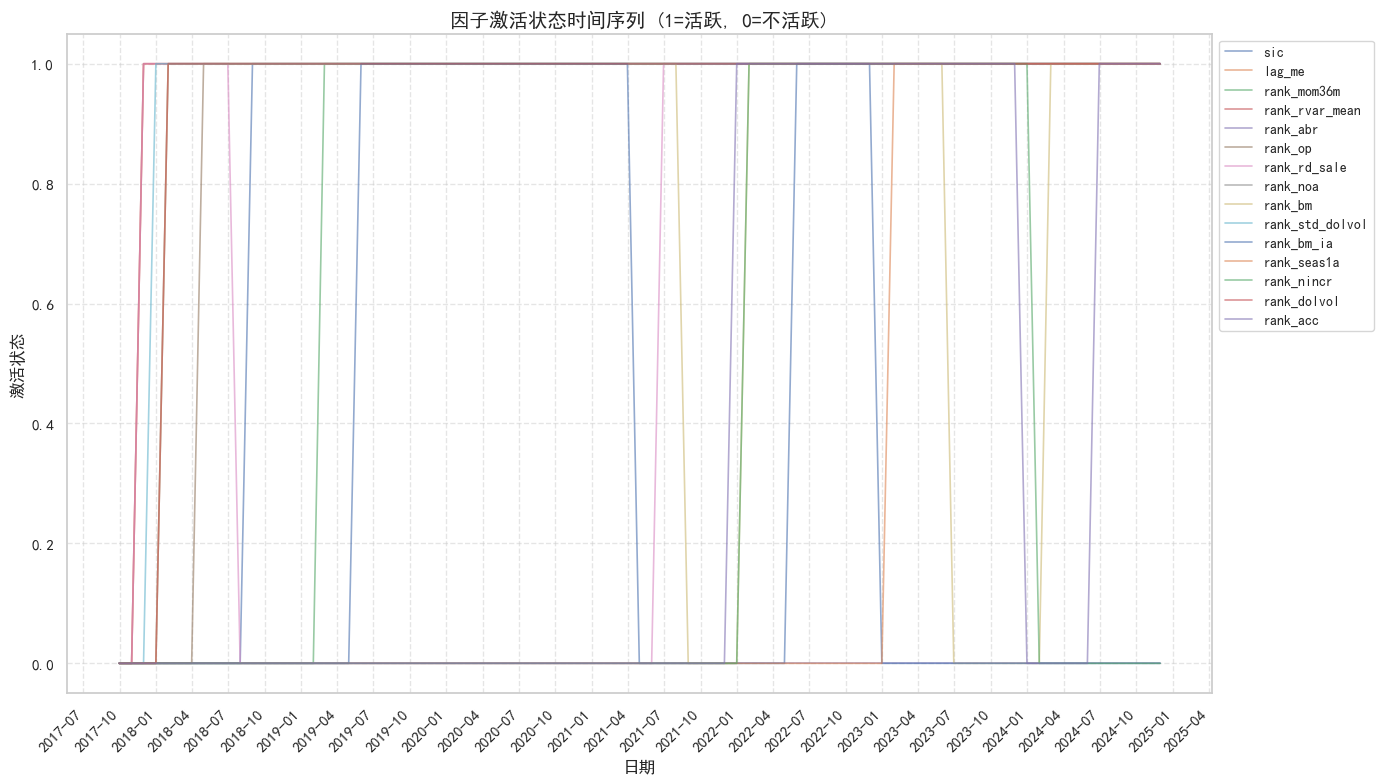

In [33]:
if __name__ == "__main__":
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'SimHei'  # 确保中文字符显示
    
    # 1. 排除非因子列，提取因子列表
    non_factor_columns = ['gvkey', 'permno', 'ret', 'date', 'ffi49', 'exchcd', 'shrcd', 'month', 'year']
    factors = [col for col in data.columns if col not in non_factor_columns and col != 'ret']
    
    print(f"检测到 {len(factors)} 个因子:")
    print(factors[:5], "... (共",{len(factors)},"个)")
    
    # 2. 初始化模型
    model = DynamicFactorModel(
        factors=factors,
        window_size=12,          # 滚动窗口大小
        min_factors=50,          # 最少激活因子数
        date_col='date',         # 日期列名
        return_col='ret',        # 收益列名
        id_col='permno',         # 股票ID列名
        model_types=['xgb','rf'],   
    )
    
    # 3. 执行滚动训练与预测
    predictions, actuals, state_history = model.train_predict(edata)
    
    # 4. 模型评估（处理多模型结果）
    eval_results = model.evaluate()
    
    if eval_results and isinstance(eval_results, dict):
        print("\n所有模型拟合效果:")
        for model_name, metrics in eval_results.items():
            if 'Error' in metrics:
                print(f"模型 {model_name} 评估失败: {metrics['Error']}")
                continue
            
            print(f"\n模型名称: {model_name}")
            print(f"预测样本数: {metrics['Number of Predictions']}")
            print(f"MSE: {metrics['MSE']:.6f}")
            print(f"RMSE: {metrics['RMSE']:.6f}")
            print(f"R²: {metrics['R²']:.4f}")
            print(f"预测与实际收益相关性: {metrics['Correlation']:.4f}")
    else:
        print("警告: 无有效评估结果")
    
    # 5. 保存预测结果到Excel
    output_path = 'D:/股票项目/dynamic_allmodel1_predictions.xlsx'
    model.save_predictions(output_path)
    print(f"\n预测结果已保存至: {output_path}")
    
    # 6. 因子状态分析与可视化
    if state_history:
        # 转换状态历史为DataFrame
        state_df = pd.DataFrame({
            'Date': [pd.Timestamp(sh[0]) for sh in state_history],
            **{factor: [sh[1][j] for sh in state_history] for j, factor in enumerate(factors)}
        })
        state_df['Date'] = pd.to_datetime(state_df['Date'])
        
        # 计算因子活跃度
        active_counts: Dict[str, int] = {factor: 0 for factor in factors}
        for state in state_history:
            active_factors = np.where(state[1] == 0)[0]  # 0表示活跃
            for idx in active_factors:
                active_counts[factors[idx]] += 1
        
        # 输出活跃度排名
        sorted_factors = sorted(active_counts.items(), key=lambda x: x[1], reverse=True)
        print("\n因子活跃度排名（活跃期数/总期数）:")
        for factor, count in sorted_factors[:10]:  # 显示前10名
            ratio = count / len(state_history)
            print(f"{factor}: {count}/{len(state_history)} ({ratio:.1%})")
        
        # 绘制因子状态时间序列图（前15个因子）
        plt.figure(figsize=(14, 8))
        for i, factor in enumerate(factors[:15]):
            # 1 - state 转换为：1=活跃，0=不活跃
            plt.plot(state_df['Date'], 1 - state_df[factor], label=factor, alpha=0.6, linewidth=1.2)
        
        # 图表美化
        plt.title('因子激活状态时间序列 (1=活跃, 0=不活跃)', fontsize=14)
        plt.xlabel('日期', fontsize=12)
        plt.ylabel('激活状态', fontsize=12)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
        plt.grid(linestyle='--', alpha=0.5)
        
        # 日期格式设置
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    else:
        print("警告: 无有效因子状态历史数据")

In [ ]:
if __name__ == "__main__":
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'SimHei'  # 确保中文字符显示
    
    # 1. 排除非因子列，提取因子列表
    non_factor_columns = ['gvkey', 'permno', 'ret', 'date', 'ffi49', 'exchcd', 'shrcd', 'month', 'year']
    factors = [col for col in data.columns if col not in non_factor_columns and col != 'ret']
    
    print(f"检测到 {len(factors)} 个因子:")
    print(factors[:5], "... (共",{len(factors)},"个)")
    
    # 2. 初始化模型
    model = DynamicFactorModel(
        factors=factors,
        window_size=12,          # 滚动窗口大小
        min_factors=50,          # 最少激活因子数
        date_col='date',         # 日期列名
        return_col='ret',        # 收益列名
        id_col='permno',         # 股票ID列名
        model_types=['mlp','enet']
    )
    
    # 3. 执行滚动训练与预测
    predictions, actuals, state_history = model.train_predict(edata)
    
    # 4. 模型评估（处理多模型结果）
    eval_results = model.evaluate()
    
    if eval_results and isinstance(eval_results, dict):
        print("\n所有模型拟合效果:")
        for model_name, metrics in eval_results.items():
            if 'Error' in metrics:
                print(f"模型 {model_name} 评估失败: {metrics['Error']}")
                continue
            
            print(f"\n模型名称: {model_name}")
            print(f"预测样本数: {metrics['Number of Predictions']}")
            print(f"MSE: {metrics['MSE']:.6f}")
            print(f"RMSE: {metrics['RMSE']:.6f}")
            print(f"R²: {metrics['R²']:.4f}")
            print(f"预测与实际收益相关性: {metrics['Correlation']:.4f}")
    else:
        print("警告: 无有效评估结果")
    
    # 5. 保存预测结果到Excel
    output_path = 'D:/股票项目/dynamic_allmodel2_predictions.xlsx'
    model.save_predictions(output_path)
    print(f"\n预测结果已保存至: {output_path}")
    
    # 6. 因子状态分析与可视化
    if state_history:
        # 转换状态历史为DataFrame
        state_df = pd.DataFrame({
            'Date': [pd.Timestamp(sh[0]) for sh in state_history],
            **{factor: [sh[1][j] for sh in state_history] for j, factor in enumerate(factors)}
        })
        state_df['Date'] = pd.to_datetime(state_df['Date'])
        
        # 计算因子活跃度
        active_counts: Dict[str, int] = {factor: 0 for factor in factors}
        for state in state_history:
            active_factors = np.where(state[1] == 0)[0]  # 0表示活跃
            for idx in active_factors:
                active_counts[factors[idx]] += 1
        
        # 输出活跃度排名
        sorted_factors = sorted(active_counts.items(), key=lambda x: x[1], reverse=True)
        print("\n因子活跃度排名（活跃期数/总期数）:")
        for factor, count in sorted_factors[:10]:  # 显示前10名
            ratio = count / len(state_history)
            print(f"{factor}: {count}/{len(state_history)} ({ratio:.1%})")
        
        # 绘制因子状态时间序列图（前15个因子）
        plt.figure(figsize=(14, 8))
        for i, factor in enumerate(factors[:15]):
            # 1 - state 转换为：1=活跃，0=不活跃
            plt.plot(state_df['Date'], 1 - state_df[factor], label=factor, alpha=0.6, linewidth=1.2)
        
        # 图表美化
        plt.title('因子激活状态时间序列 (1=活跃, 0=不活跃)', fontsize=14)
        plt.xlabel('日期', fontsize=12)
        plt.ylabel('激活状态', fontsize=12)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
        plt.grid(linestyle='--', alpha=0.5)
        
        # 日期格式设置
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    else:
        print("警告: 无有效因子状态历史数据")

检测到 63 个因子:
['sic', 'lag_me', 'rank_mom36m', 'rank_rvar_mean', 'rank_abr'] ... (共 {63} 个)
11 轮已经完成
12 轮已经完成
13 轮已经完成
14 轮已经完成
15 轮已经完成
16 轮已经完成
17 轮已经完成
18 轮已经完成
19 轮已经完成
20 轮已经完成
21 轮已经完成
22 轮已经完成
23 轮已经完成
24 轮已经完成
25 轮已经完成
26 轮已经完成
27 轮已经完成
28 轮已经完成
29 轮已经完成
30 轮已经完成
31 轮已经完成
32 轮已经完成
33 轮已经完成
34 轮已经完成
35 轮已经完成
36 轮已经完成
37 轮已经完成
38 轮已经完成
39 轮已经完成
40 轮已经完成
41 轮已经完成
42 轮已经完成
43 轮已经完成
44 轮已经完成
45 轮已经完成
46 轮已经完成
47 轮已经完成
48 轮已经完成
49 轮已经完成
50 轮已经完成
51 轮已经完成
52 轮已经完成
53 轮已经完成
54 轮已经完成
55 轮已经完成
56 轮已经完成
57 轮已经完成
58 轮已经完成
59 轮已经完成
60 轮已经完成
61 轮已经完成
62 轮已经完成
63 轮已经完成
64 轮已经完成
65 轮已经完成
66 轮已经完成
67 轮已经完成
68 轮已经完成
69 轮已经完成
70 轮已经完成
71 轮已经完成
72 轮已经完成


d:\Anaconda1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


73 轮已经完成


In [ ]:
if __name__ == "__main__":
    # 排除标识列和收益列
    non_factor_columns = ['gvkey', 'permno',  'ret', 'date', 'ffi49', 'exchcd','shrcd', 'month', 'year']
    all_columns = data.columns.tolist()
    factors = [col for col in all_columns if col not in non_factor_columns]
    
    print(f"使用的因子列表({len(factors)}个):")
    print(factors)
    
    # 初始化模型
    model = DynamicFactorModel(
        factors=factors,
        window_size=18,  
        min_factors=50,   # 最少启用50个因子
        date_col='date', # 日期列名
        return_col='ret', # 收益列名
        id_col='permno'  # 股票ID列名
    )
    
    # 运行滚动预测
    predictions, actuals, state_history = model.train_predict(edata)
    
    # 评估模型
    ic_results = model.evaluate(predictions, actuals)
    print("\n模型评估结果:")
    print(f"预测数量: {ic_results['Number of Predictions']}")
    print(f"MSE: {ic_results['MSE']:.6f}")
    print(f"RMSE: {ic_results['RMSE']:.6f}")
    print(f"R²: {ic_results['R²']:.4f}")

    # 获取预测结果DataFrame
    model.save_predictions('D:/股票项目/dynamic_predictions.xlsx', file_format='xlsx')
    
    # 提取状态历史
    state_df = pd.DataFrame({
        'Date': [sh[0] for sh in state_history],
        **{factors[j]: [sh[1][j] for sh in state_history] for j in range(len(factors))}
    })

    # 绘制因子状态时间序列
    plt.figure(figsize=(14, 8))
    for i, factor in enumerate(factors[:15]):  # 只展示前15个因子
        plt.plot(state_df['Date'], 1 - state_df[factor], label=factor, alpha=0.7)

    plt.title('Factor Activation State Over Time (1=Active, 0=Inactive)')
    plt.xlabel('Date')
    plt.ylabel('Activation State')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 分析因子活跃度
    active_counts = {factor: 0 for factor in factors}
    for date, state in state_history:
        for j, factor in enumerate(factors):
            if state[j] == 0:  # 因子活跃
                active_counts[factor] += 1
                
    # 按活跃度排序
    sorted_factors = sorted(active_counts.items(), key=lambda x: x[1], reverse=True)
    print("\n因子活跃度排名:")
    for factor, count in sorted_factors:
        print(f"{factor}: {count}/{len(state_history)} 期 ({count/len(state_history):.1%})")

使用的因子列表(63个):
['sic', 'lag_me', 'rank_mom36m', 'rank_rvar_mean', 'rank_abr', 'rank_op', 'rank_rd_sale', 'rank_noa', 'rank_bm', 'rank_std_dolvol', 'rank_bm_ia', 'rank_seas1a', 'rank_nincr', 'rank_dolvol', 'rank_acc', 'rank_adm', 'rank_mom12m', 'rank_ato', 'rank_pm', 'rank_rsup', 'rank_chtx', 'rank_rvar_ff3', 'rank_baspread', 'rank_std_turn', 'rank_agr', 'rank_pctacc', 'rank_beta', 'rank_rdm', 'rank_roe', 'rank_ill', 'rank_sue', 'rank_sgr', 'rank_chpm', 'rank_lgr', 'rank_alm', 'rank_herf', 'rank_depr', 'rank_mom1m', 'rank_ep', 'rank_pscore', 'rank_cash', 'rank_mom60m', 'rank_rna', 'rank_rvar_capm', 'rank_gma', 'rank_chcsho', 'rank_mom6m', 'rank_zerotrade', 'rank_turn', 'rank_sp', 'rank_cinvest', 'rank_dy', 'rank_maxret', 'rank_lev', 'rank_me_ia', 'rank_cfp', 'rank_hire', 'rank_cashdebt', 'rank_me', 'rank_ni', 'rank_roa', 'rank_grltnoa', 'log_me']


KeyboardInterrupt: 

### 板块模型

In [14]:
usa_dta =  pd.read_excel('C:/Users/Lenovo/Desktop/USA macro_vars.xlsx')
usa_dta = usa_dta.fillna(method= 'ffill')
usa_dta = usa_dta.dropna()
usa_dta.reset_index(inplace = True, drop = True)
usa_dta['date'] = pd.to_datetime(usa_dta['date'])
adata = pd.merge(edata, usa_dta, on = ['date'], how = 'left')
adata

,gvkey,permno,sic,ret,exchcd,shrcd,date,ffi49,lag_me,rank_mom36m,...,market_ret,GDP,savings,gf,cpi,value,bp,oil,unemp,pmi
0,12825,10026,2050,-0.033289,3.0,11.0,2017-05-31,2,2.519068e+06,0.122405,...,-0.008713,4674.704,181.737,-88.423,244.004,27352200.72,2411.80,49.40,4.4,56.4
1,12825,10026,2050,0.018371,3.0,11.0,2017-06-30,2,2.435212e+06,0.000000,...,0.015313,4889.678,172.120,-90.233,244.163,27352200.72,2423.41,47.08,4.3,56.2
2,12825,10026,2050,-0.005073,3.0,11.0,2017-07-31,2,2.473539e+06,0.000000,...,0.000371,4889.678,172.120,-42.939,244.243,27352200.72,2470.30,51.99,4.3,56.5
3,12825,10026,2050,-0.029756,3.0,11.0,2017-08-31,2,2.462304e+06,0.000000,...,-0.016907,4889.678,172.120,-107.689,245.183,27352200.72,2471.65,52.69,4.4,58.4
4,12825,10026,2050,0.033179,3.0,11.0,2017-09-30,2,2.389035e+06,0.000000,...,0.073296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316382,184996,93436,3711,-0.077391,3.0,11.0,2024-08-31,23,7.413801e+08,0.110106,...,-0.024281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316383,184996,93436,3711,0.221942,3.0,11.0,2024-09-30,23,6.840044e+08,0.141393,...,0.003945,7364.675,379.659,64.263,314.851,40297980.32,5762.48,72.35,4.1,47.5
316384,184996,93436,3711,-0.045025,3.0,11.0,2024-10-31,23,8.390474e+08,-0.015357,...,-0.001507,7364.675,379.659,-257.450,315.564,40297980.32,5705.45,73.25,4.1,46.9
316385,184996,93436,3711,0.381469,3.0,11.0,2024-11-30,23,8.020335e+08,-0.099911,...,0.100034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
class IndustryFactorModel:
    def __init__(self, 
                 date_col='date', 
                 return_col='ret', 
                 id_col='permno', 
                 industry_col='ffi49',
                 ic_threshold=0.05,    # IC绝对值阈值
                 min_industry_stocks=30,  # 最小股票数量
                 min_factors=2):       # 每个行业最小因子数量
        self.date_col = date_col
        self.return_col = return_col
        self.id_col = id_col
        self.industry_col = industry_col
        self.ic_threshold = ic_threshold
        self.min_industry_stocks = min_industry_stocks
        self.min_factors = min_factors
        
        # 存储行业-因子映射和模型
        self.industry_factors = {}  # 行业 -> 有效因子
        self.industry_models = {}   # 行业 -> 模型
        self.industry_metrics = {}  # 行业 -> 模型评估指标
        
    def identify_industry_factors(self, data):
        """识别每个行业的有效因子（基于全量数据）"""
        # 提取所有因子列
        non_factor_cols = ['gvkey', 'permno', 'ret', 'date', 'ffi49', 'exchcd', 'shrcd', 'month', 'year']
        all_factors = [col for col in data.columns if col not in non_factor_cols]
        
        # 获取所有行业
        industries = data[self.industry_col].dropna().unique()
        
        # 对每个行业计算因子IC
        for industry in industries:
            industry_data = data[data[self.industry_col] == industry]
            
            # 检查行业样本量
            if len(industry_data[self.id_col].unique()) < self.min_industry_stocks:
                print(f"行业 {industry} 样本量不足 ({len(industry_data)}), 跳过")
                continue
                
            # 计算每个因子的IC
            industry_factors_ic = {}
            for factor in all_factors:
                if factor not in industry_data.columns:
                    continue
                    
                # 计算因子与收益的IC
                valid_data = industry_data.dropna(subset=[factor, self.return_col])
                if len(valid_data) < 20:  # 最小样本量
                    continue
                    
                ic, _ = spearmanr(valid_data[factor], valid_data[self.return_col])
                industry_factors_ic[factor] = abs(ic)  # 使用IC绝对值
                
            # 筛选有效因子（IC绝对值大于阈值）
            valid_factors = [factor for factor, ic in industry_factors_ic.items() 
                             if ic >= self.ic_threshold]
                             
            # 如果有效因子不足，选择IC最高的因子
            if len(valid_factors) < self.min_factors:
                sorted_factors = sorted(industry_factors_ic.items(), key=lambda x: x[1], reverse=True)
                valid_factors = [factor for factor, _ in sorted_factors[:self.min_factors]]
                
            self.industry_factors[industry] = valid_factors
            print(f"行业 {industry} 筛选出 {len(valid_factors)} 个有效因子")
            
        return self.industry_factors
        
    def train_industry_models(self, data):
        """为每个行业训练独立模型（基于全量数据）"""
        if not self.industry_factors:
            raise ValueError("请先调用 identify_industry_factors 方法筛选行业因子")
            
        # 为每个行业训练模型
        for industry, factors in self.industry_factors.items():
            industry_data = data[data[self.industry_col] == industry]
            
            if industry_data.empty:
                print(f"行业 {industry} 无数据，跳过")
                continue
                
            # 准备特征和目标变量
            X = industry_data[factors]
            y = industry_data[self.return_col]
            
            # 训练XGBoost模型
            model = XGBRegressor(
                n_estimators=50, 
                max_depth=3, 
                learning_rate=0.1,
                subsample=0.8, 
                colsample_bytree=0.8, 
                reg_alpha=1,
                reg_lambda=1, 
                objective='reg:squarederror', 
                random_state=42, 
                n_jobs=-1
            )
            
            model.fit(X, y)
            
            # 评估模型
            y_pred = model.predict(X)
            mse = mean_squared_error(y, y_pred)
            r2 = r2_score(y, y_pred)
            
            self.industry_models[industry] = model
            self.industry_metrics[industry] = {
                'mse': mse,
                'rmse': np.sqrt(mse),
                'r2': r2,
                'n_samples': len(industry_data),
                'factors': factors
            }
            
            print(f"行业 {industry} 模型训练完成 - R²: {r2:.4f}, 样本量: {len(industry_data)}")
            
        return self.industry_models, self.industry_metrics
        
    def predict(self, data):
        """使用行业模型进行预测"""
        if not self.industry_models:
            raise ValueError("请先调用 train_industry_models 方法训练模型")
            
        predictions = []
        
        # 对每个行业进行预测
        for industry, model in self.industry_models.items():
            industry_data = data[data[self.industry_col] == industry].copy()
            factors = self.industry_factors[industry]
            
            if industry_data.empty:
                continue
                
            # 检查因子是否存在
            missing_factors = [f for f in factors if f not in industry_data.columns]
            if missing_factors:
                print(f"行业 {industry} 缺失因子: {missing_factors}")
                continue
                
            # 预测
            industry_data['predicted_return'] = model.predict(industry_data[factors])
            predictions.append(industry_data[[self.id_col, self.date_col, self.industry_col, 
                                           'predicted_return', self.return_col]])
            
        # 合并所有行业的预测结果
        if predictions:
            return pd.concat(predictions, ignore_index=True)
        else:
            return pd.DataFrame()
            
    def get_predictions(self, data, output_cols=None):
        """获取预测结果"""
        # 执行预测
        pred_df = self.predict(data)
        
        if pred_df.empty:
            return pd.DataFrame()
            
        # 设置默认输出列
        if output_cols is None:
            output_cols = [self.id_col, self.date_col, 'predicted_return']
        
        # 确保所有列都存在
        missing_cols = [col for col in output_cols if col not in pred_df.columns]
        if missing_cols:
            raise ValueError(f"缺失列: {missing_cols}")
            
        return pred_df[output_cols].rename(columns={
            'predicted_return': 'ret_predict',  # 重命名为ret_predict
            self.id_col: 'permno',
            self.date_col: 'date'
        })

In [16]:
# 初始化行业因子模型
model = IndustryFactorModel(
    date_col='date',
    return_col='ret',
    id_col='permno',
    industry_col='ffi49',
    ic_threshold=0.01,      # IC绝对值阈值
    min_industry_stocks=30, # 最小股票数量
    min_factors=30           # 每个行业最小因子数量
)

# 步骤1: 识别每个行业的有效因子
industry_factors = model.identify_industry_factors(adata)

# 步骤2: 为每个行业训练模型
industry_models, industry_metrics = model.train_industry_models(adata)

# 步骤3: 获取预测结果（仅包含permno, date, ret_predict）
ipredictions = model.get_predictions(adata)
print(f"预测结果: {len(ipredictions)} 条记录")

# 保存预测结果
ipredictions.to_excel('D:/股票项目/industry_predictions.xlsx', index=False)

# 查看结果示例
print("\n预测结果示例:")
print(ipredictions.head())

d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 2 筛选出 66 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 43 筛选出 65 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 37 筛选出 61 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 11 筛选出 68 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 36 筛选出 70 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 48 筛选出 62 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 49 筛选出 69 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 18 筛选出 66 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 13 筛选出 69 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 42 筛选出 58 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 21 筛选出 63 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 45 筛选出 59 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 46 筛选出 63 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 14 筛选出 60 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 41 筛选出 63 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 47 筛选出 63 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 34 筛选出 57 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 17 筛选出 66 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 12 筛选出 71 个有效因子
行业 16 样本量不足 (643), 跳过


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 22 筛选出 71 个有效因子
行业 3 样本量不足 (675), 跳过


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 38 筛选出 67 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 31 筛选出 62 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 30 筛选出 67 个有效因子
行业 1 样本量不足 (847), 跳过


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 9 筛选出 63 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 7 筛选出 61 个有效因子
行业 27 样本量不足 (864), 跳过
行业 24 样本量不足 (1891), 跳过


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 32 筛选出 57 个有效因子
行业 4 样本量不足 (917), 跳过


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 23 筛选出 72 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 44 筛选出 58 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 10 筛选出 61 个有效因子


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 39 筛选出 64 个有效因子
行业 25 样本量不足 (876), 跳过


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 19 筛选出 48 个有效因子
行业 28 样本量不足 (1333), 跳过


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 35 筛选出 58 个有效因子
行业 15 样本量不足 (1292), 跳过


d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\Anaconda1\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


行业 33 筛选出 65 个有效因子
行业 5 样本量不足 (466), 跳过
行业 8 样本量不足 (1136), 跳过
行业 26 样本量不足 (853), 跳过
行业 20 样本量不足 (467), 跳过
行业 6 样本量不足 (1708), 跳过
行业 29 样本量不足 (744), 跳过
行业 40 样本量不足 (863), 跳过
行业 2 模型训练完成 - R²: 0.3524, 样本量: 4061
行业 43 模型训练完成 - R²: 0.6672, 样本量: 13536
行业 37 模型训练完成 - R²: 0.2704, 样本量: 12794
行业 11 模型训练完成 - R²: 0.2995, 样本量: 5069
行业 36 模型训练完成 - R²: 0.2546, 样本量: 27890
行业 48 模型训练完成 - R²: 0.3427, 样本量: 8804
行业 49 模型训练完成 - R²: 0.3400, 样本量: 5049
行业 18 模型训练完成 - R²: 0.5201, 样本量: 4155
行业 13 模型训练完成 - R²: 0.1139, 样本量: 48006
行业 42 模型训练完成 - R²: 0.3905, 样本量: 8187
行业 21 模型训练完成 - R²: 0.6670, 样本量: 8285
行业 45 模型训练完成 - R²: 0.4067, 样本量: 36749
行业 46 模型训练完成 - R²: 0.3485, 样本量: 8907
行业 14 模型训练完成 - R²: 0.3302, 样本量: 6097
行业 41 模型训练完成 - R²: 0.3612, 样本量: 5939
行业 47 模型训练完成 - R²: 0.5082, 样本量: 2821
行业 34 模型训练完成 - R²: 0.2439, 样本量: 14496
行业 17 模型训练完成 - R²: 0.5677, 样本量: 4479
行业 12 模型训练完成 - R²: 0.2279, 样本量: 12513
行业 22 模型训练完成 - R²: 0.4198, 样本量: 4516
行业 38 模型训练完成 - R²: 0.3341, 样本量: 5289
行业 31 模型训练完成 - R²: 0.4574, 样本量: 6850
行业 30 模型


最广泛有效的因子:
market_ret         33
rank_rvar_mean     33
industry_ret       33
rank_noa           33
oil                33
rank_std_dolvol    33
unemp              33
rank_baspread      32
rank_rvar_ff3      32
value              32
dtype: int64


<Axes: title={'center': 'Top 20 Most Popular Factors Across Industries'}>

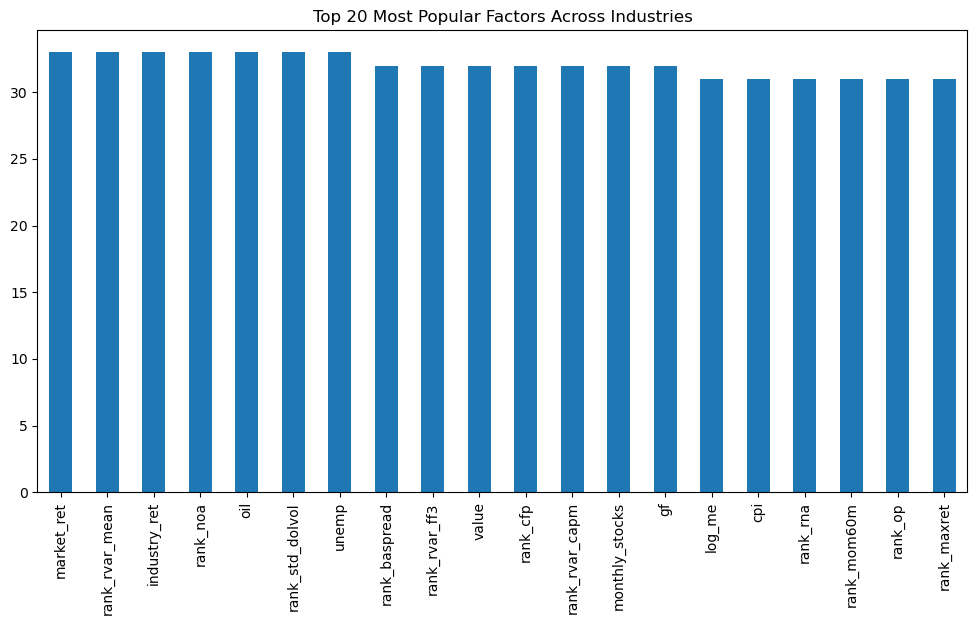

In [17]:
# 查看各行业有效因子分布
factor_distribution = {}
for industry, factors in industry_factors.items():
    for factor in factors:
        if factor not in factor_distribution:
            factor_distribution[factor] = 0
        factor_distribution[factor] += 1

# 按行业出现频率排序
factor_popularity = pd.Series(factor_distribution).sort_values(ascending=False)
print("\n最广泛有效的因子:")
print(factor_popularity.head(10))

# 可视化
factor_popularity.head(20).plot(kind='bar', figsize=(12, 6), 
                               title='Top 20 Most Popular Factors Across Industries')

In [18]:
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'SimHei'  # 确保中文字符显示

# 1. 每个行业模型的R²分布可视化
def plot_r2_distribution(industry_metrics):
    """
    绘制各行业模型R²的分布情况
    """
    # 提取R²数据
    r2_data = []
    for industry, metrics in industry_metrics.items():
        r2_data.append({
            'Industry': industry,
            'R²': metrics['r2'],
            'Adj_R²': metrics.get('adj_r2', metrics['r2'])
        })
    
    r2_df = pd.DataFrame(r2_data).melt(id_vars='Industry', var_name='Metric', value_name='Value')
    
    # 创建图表
    plt.figure(figsize=(14, 8))
    
    # 使用箱线图展示分布
    ax = sns.boxplot(x='Industry', y='Value', hue='Metric', data=r2_df, palette="Set2")
    plt.title('各行业模型R2分布', fontsize=16)
    plt.ylabel('R2值', fontsize=12)
    plt.xlabel('行业代码', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='指标类型', loc='upper right')
    
    # 添加横向网格线
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 调整布局
    plt.tight_layout()
    plt.savefig('industry_r2_distribution.png', dpi=300)
    plt.show()



In [19]:
# 2. 每个行业模型的因子数量分布
def plot_factor_distribution(industry_factors):
    """
    绘制各行业使用的有效因子数量分布
    """
    # 计算每个行业的因子数量
    factor_counts = {industry: len(factors) for industry, factors in industry_factors.items()}
    count_df = pd.DataFrame(list(factor_counts.items()), columns=['Industry', 'Factor Count'])
    
    # 创建图表
    plt.figure(figsize=(14, 8))
    
    # 使用条形图展示
    ax = sns.barplot(x='Industry', y='Factor Count', data=count_df, palette="viridis")
    plt.title('各行业有效因子数量分布', fontsize=16)
    plt.ylabel('有效因子数量', fontsize=12)
    plt.xlabel('行业代码', fontsize=12)
    plt.xticks(rotation=45)
    
    # 在柱子上方显示数值
    for p in ax.patches:
        ax.annotate(f"{int(p.get_height())}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=9)
    
    # 设置y轴为整数刻度
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.savefig('industry_factor_counts.png', dpi=300)
    plt.show()
    
    # 返回统计数据
    return count_df.describe()

In [20]:
# 3. 有效因子跨行业分布（流行度）
def plot_factor_popularity(factor_popularity, top_n=20):
    """
    绘制最流行的有效因子分布（跨行业出现频率）
    """
    # 创建图表
    plt.figure(figsize=(14, 10))
    
    # 取前N个最流行的因子
    top_factors = factor_popularity.head(top_n)
    
    # 使用水平条形图
    ax = sns.barplot(x=top_factors.values, y=top_factors.index, palette="rocket_r")
    plt.title(f'Top {top_n} 跨行业流行因子', fontsize=16)
    plt.xlabel('覆盖行业数量', fontsize=12)
    plt.ylabel('因子名称', fontsize=12)
    
    # 在条形上显示数值
    for i, v in enumerate(top_factors.values):
        ax.text(v + 0.5, i, str(v), color='black', ha='left', va='center', fontsize=10)
    
    # 添加垂直参考线
    mean_val = factor_popularity.mean()
    plt.axvline(x=mean_val, color='red', linestyle='--', alpha=0.7)
    plt.text(mean_val + 0.5, top_n//2, f'均值: {mean_val:.1f}', 
             color='red', fontsize=12, rotation=90)
    
    plt.tight_layout()
    plt.savefig('factor_popularity.png', dpi=300)
    plt.show()
    
    # 返回统计数据
    return factor_popularity.describe()

In [21]:
# 4. 行业模型性能与因子数量关系
def plot_performance_vs_factors(industry_metrics, industry_factors):
    """
    绘制行业模型性能与因子数量关系图
    """
    # 准备数据
    data = []
    for industry, metrics in industry_metrics.items():
        data.append({
            'Industry': industry,
            'R2': metrics['r2'],
            'Factor_Count': len(industry_factors[industry])
        })
    
    perf_df = pd.DataFrame(data)
    
    # 创建图表
    plt.figure(figsize=(12, 8))
    
    # 使用散点图展示关系
    ax = sns.scatterplot(x='Factor_Count', y='R2', data=perf_df, 
                         s=150, hue='R2', palette="coolwarm", 
                         size='R2', sizes=(50, 300))
    
    # 添加行业标签
    for i, row in perf_df.iterrows():
        ax.text(row['Factor_Count'] + 0.2, row['R2'] + 0.01, 
                row['Industry'], fontsize=9, alpha=0.8)
    
    # 添加回归线
    sns.regplot(x='Factor_Count', y='R2', data=perf_df, 
                scatter=False, color='grey', ci=None)
    
    plt.title('行业模型性能 vs 有效因子数量', fontsize=16)
    plt.xlabel('使用的有效因子数量', fontsize=12)
    plt.ylabel('模型R2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # 添加相关系数
    corr = perf_df['Factor_Count'].corr(perf_df['R2'])
    plt.text(0.05, 0.95, f'相关系数: {corr:.2f}', 
             transform=ax.transAxes, fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('performance_vs_factors.png', dpi=300)
    plt.show()
    
    return corr

可视化1: 行业模型R2分布


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_50508\1621162753.py:35: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_50508\1621162753.py:36: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.savefig('industry_r2_distribution.png', dpi=300)
d:\Anaconda1\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


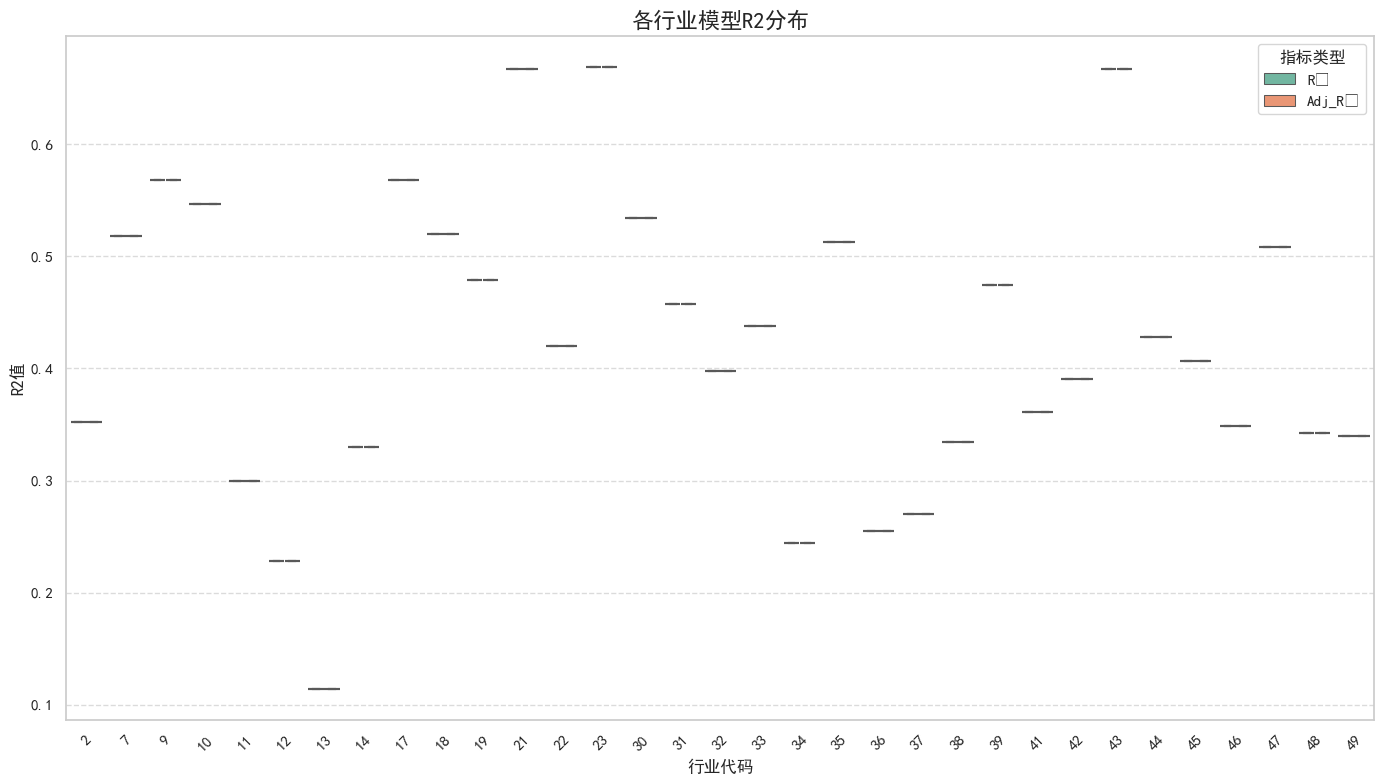


可视化2: 行业因子数量分布


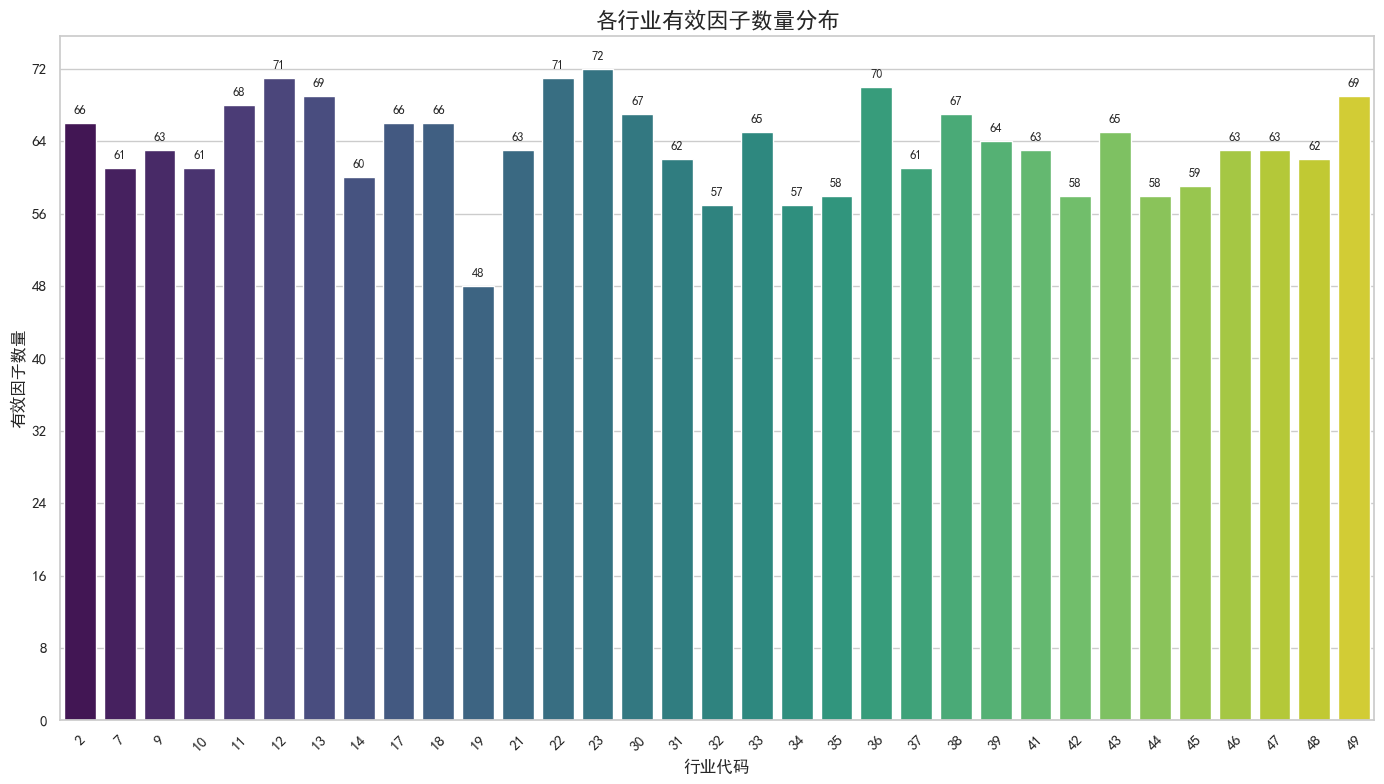


行业因子数量统计:
        Industry  Factor Count
count  33.000000     33.000000
mean   28.727273     63.424242
std    14.062967      5.086934
min     2.000000     48.000000
25%    17.000000     61.000000
50%    32.000000     63.000000
75%    41.000000     67.000000
max    49.000000     72.000000

可视化3: 有效因子流行度


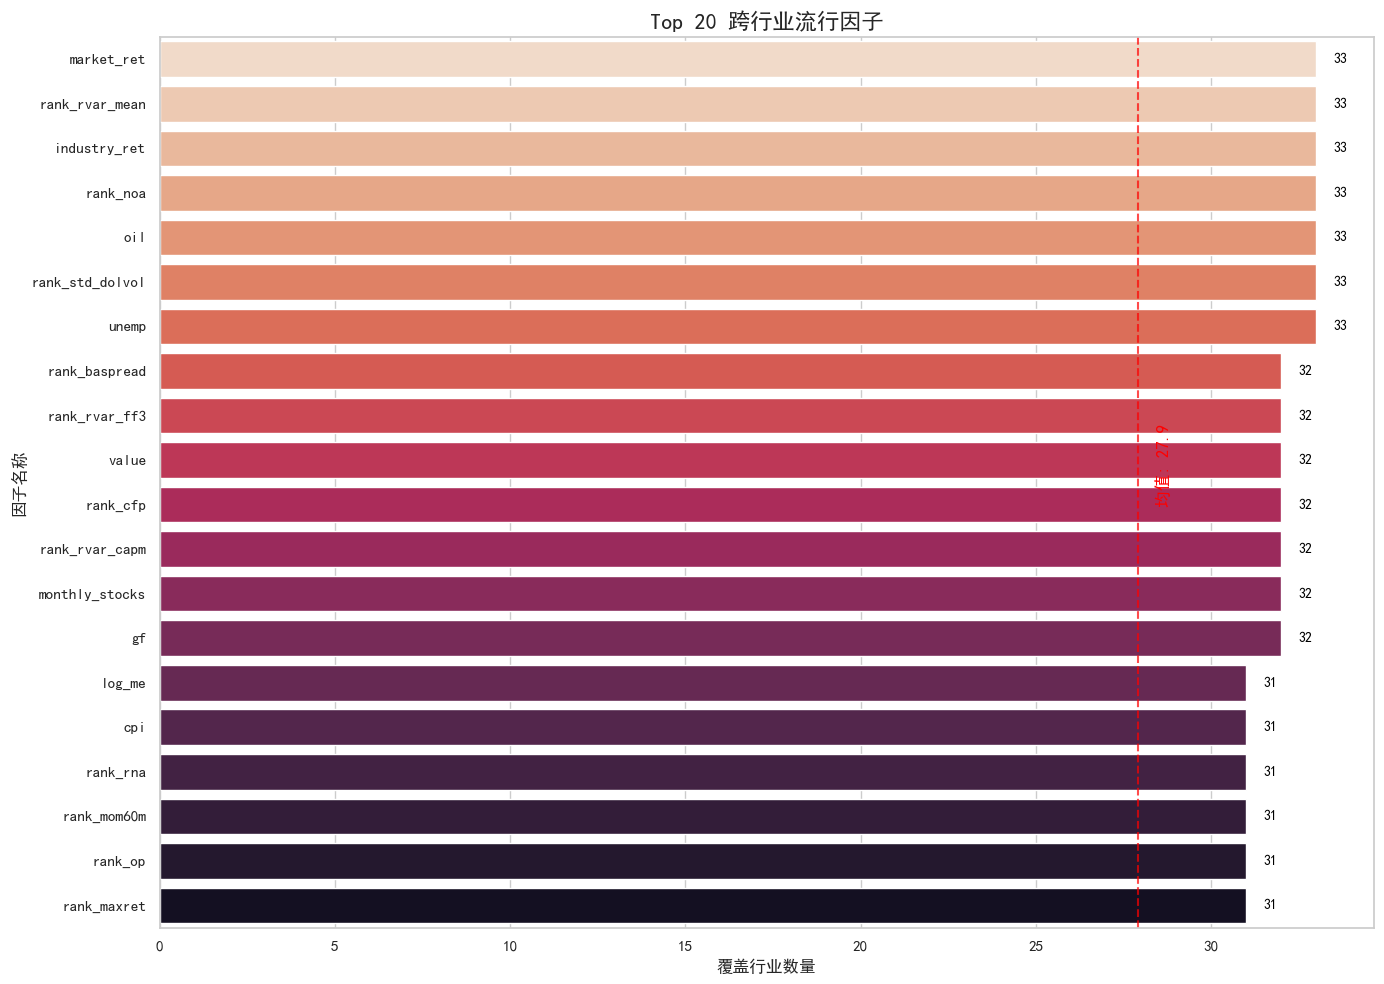


因子流行度统计:
count    75.000000
mean     27.906667
std       4.208015
min      17.000000
25%      26.000000
50%      29.000000
75%      31.000000
max      33.000000
dtype: float64

可视化4: 模型性能与因子数量关系


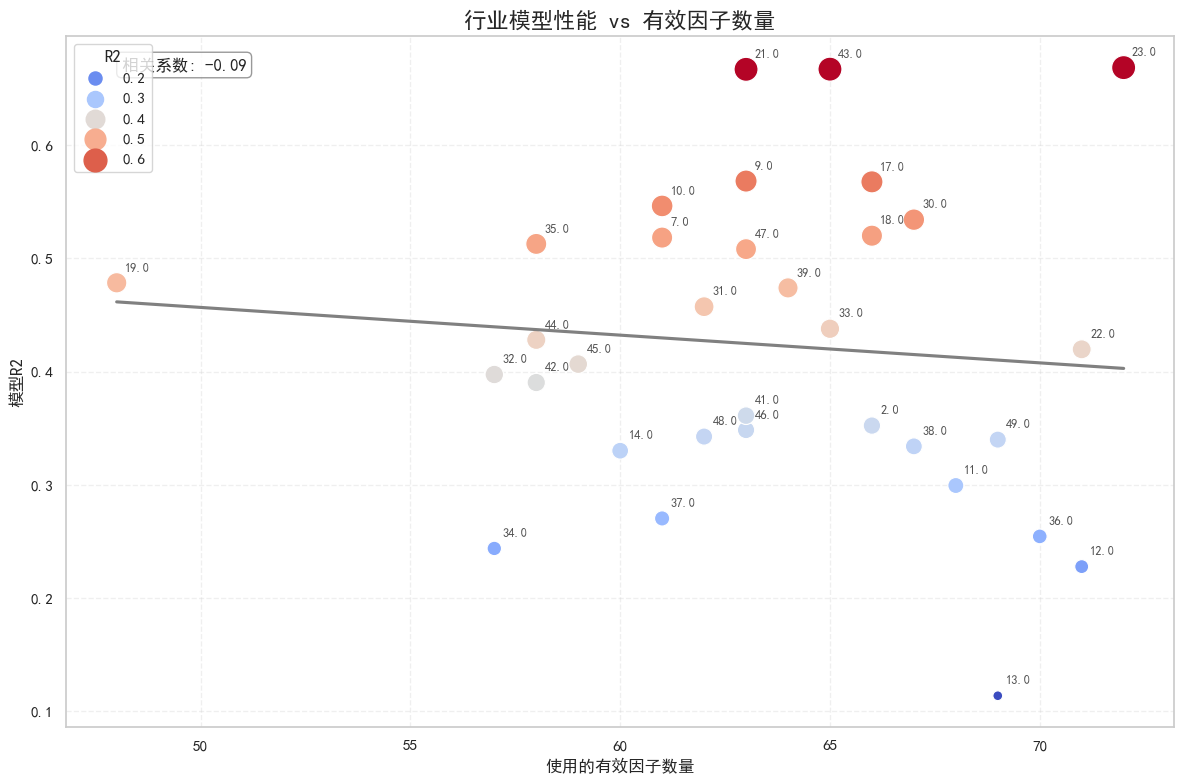


R²与因子数量的相关系数: -0.0934


In [22]:
# ======= 执行可视化 =======
if __name__ == "__main__":
    # 假设已有以下数据:
    # industry_metrics = 每个行业的模型评估指标
    # industry_factors = 每个行业的有效因子列表
    # factor_popularity = 因子的行业覆盖度Series
    
    print("可视化1: 行业模型R2分布")
    plot_r2_distribution(industry_metrics)
    
    print("\n可视化2: 行业因子数量分布")
    factor_count_stats = plot_factor_distribution(industry_factors)
    print("\n行业因子数量统计:")
    print(factor_count_stats)
    
    print("\n可视化3: 有效因子流行度")
    factor_popularity_stats = plot_factor_popularity(factor_popularity)
    print("\n因子流行度统计:")
    print(factor_popularity_stats)
    
    print("\n可视化4: 模型性能与因子数量关系")
    performance_corr = plot_performance_vs_factors(industry_metrics, industry_factors)
    print(f"\nR²与因子数量的相关系数: {performance_corr:.4f}")